In [1]:
import os
from collections import OrderedDict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import torch
import torchvision
from torch import nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from albumentations.augmentations import transforms
import albumentations as A
from albumentations import RandomRotate90,Resize
import yaml
from torchvision.utils import save_image
import torch.nn.functional as F
from tqdm import tqdm
import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
from mmcv.cnn import ConvModule
import pdb
from dataloader import Dataset
from arch.DS_STM_Net import Ds_StmNet
from metrics import iou_score
from utils import AverageMeter
from losses import LovaszHingeLoss

## param

In [2]:
config = {}
config['name'] = 'BUSI_1203_Ds_StmNet'
config['dataset'] = 'Dataset_BUSI_with_GT'
config['epochs'] = 800
config['input_channels'] = 3
config['output_channels'] = 1
config['input_hw'] = 512
config['lr'] = 1e-4
config['momentum'] = 0.9
config['weight_decay'] = 3e-4
config['batch_size'] = 4
config['num_workers'] = 8
config['min_lr'] = 1e-6
config['result_dir'] = os.path.join('./result',config['name'])
config['isPretrain'] = True
config['pretrain_name'] = 'BUSI_1202_Ds_StmNet'
if not os.path.exists(os.path.join('./result',config['pretrain_name'])):
    config['pretrain_dir'] = None
else :
    config['pretrain_dir'] = os.path.join('./result',config['pretrain_name'])
config

{'name': 'BUSI_1203_Ds_StmNet',
 'dataset': 'Dataset_BUSI_with_GT',
 'epochs': 800,
 'input_channels': 3,
 'output_channels': 1,
 'input_hw': 512,
 'lr': 0.0001,
 'momentum': 0.9,
 'weight_decay': 0.0003,
 'batch_size': 4,
 'num_workers': 8,
 'min_lr': 1e-06,
 'result_dir': './result/BUSI_1203_Ds_StmNet',
 'isPretrain': True,
 'pretrain_name': 'BUSI_1202_Ds_StmNet',
 'pretrain_dir': './result/BUSI_1202_Ds_StmNet'}

In [14]:
if not os.path.exists(config['result_dir']):
    os.makedirs(config['result_dir'])

## dataset

In [9]:
train_img_ids = np.load(os.path.join('./datasets',config['dataset'],'train_img_ids.npy'))
valid_img_ids = np.load(os.path.join('./datasets',config['dataset'],'valid_img_ids.npy'))
len(valid_img_ids)

130

In [16]:
train_transform = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
])

train_dataset = Dataset(
    dataset=config['dataset'],
    img_names=train_img_ids,
    transform=train_transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'])

# 没有测试集么？
valid_transform = A.Compose([
#     A.Normalize(),  # 也不需要
])

valid_dataset = Dataset(
    dataset=config['dataset'],
    img_names=valid_img_ids,
    transform=valid_transform
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'])

## model

In [17]:
model = Ds_StmNet(num_classes=1, input_channels=3,img_size=512)
params = list(model.parameters())
num_params = sum([p.numel() for p in params]) / 1e6
print("模型参数量：{}M个".format(num_params))
device = torch.device('cuda')
model = model.to(device)
# print(a)
X = torch.rand(size=(1,3,512,512),dtype=torch.float32)
X = X.to(device)
X= model(X)
print(X.shape)
del model
del X
torch.cuda.empty_cache()

模型参数量：7.473105M个
torch.Size([1, 1, 512, 512])


/_chenqi45w/anaconda3/envs/unext/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


## train

In [18]:
def train(config, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    model.train()

    pbar = tqdm(total=len(train_loader))
    for input_, target_ in train_loader:
#         print("train:",input_.max(),input_.min(),target_.max(),target_.min())
        input_ = input_.cuda()
        target_ = target_.cuda()

        output = model(input_)
        loss = criterion(output, target_)
        iou,dice = iou_score(output, target_)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), input_.size(0))
        avg_meters['iou'].update(iou, input_.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])

## valid

In [19]:
def validate(config, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter(),
                   'dice': AverageMeter()}

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input_, target_ in val_loader:
#             print("valid:",input_.max(),input_.min(),target_.max(),target_.min())
            input_ = input_.cuda()
            target_ = target_.cuda()

            output = model(input_)
            loss = criterion(output, target_)
            iou,dice = iou_score(output, target_)

            avg_meters['loss'].update(loss.item(), input_.size(0))
            avg_meters['iou'].update(iou, input_.size(0))
            avg_meters['dice'].update(dice, input_.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
                ('dice', avg_meters['dice'].avg)
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg)])

## run

In [ ]:
cudnn.benchmark = True
# criterion = nn.BCEWithLogitsLoss().cuda()
criterion = LovaszHingeLoss().cuda()
model = Ds_StmNet(num_classes=1, input_channels=3,img_size=256)
if config['isPretrain'] and config['pretrain_dir'] is not None:
    print("loading model...")
    model.load_state_dict(torch.load(os.path.join(config['pretrain_dir'],'model.pth')),strict=True)
    print("load model success!")
else:
    print("no pretrain")
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'], eta_min=config['min_lr'])

log = OrderedDict([
    ('epoch', []),
    ('lr', []),
    ('loss', []),
    ('iou', []),
    ('val_loss', []),
    ('val_iou', []),
    ('val_dice', []),
])

best_iou = 0

start_time = time.time()
for epoch in range(config['epochs']):
    print('Epoch [%d/%d]' % (epoch, config['epochs']))
    # train for one epoch
    train_log = train(config, train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(config, valid_loader, model, criterion)

    print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
          % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))
    log['epoch'].append(epoch)
    log['lr'].append(optimizer.state_dict()['param_groups'][0]['lr'])
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])
    log['val_dice'].append(val_log['dice'])

    if val_log['iou'] > best_iou:
        torch.save(model.state_dict(), 'result/%s/model.pth' %
                   config['name'])
        best_iou = val_log['iou']
        print("=> saved best model")
    
    pd.DataFrame(log).to_csv('result/%s/log.csv' %
                         config['name'], index=False)
    scheduler.step()
    torch.cuda.empty_cache()
end_time = time.time()
print("best iou: %.4f"%best_iou)
print('Running time: %s Seconds' % (end_time - start_time))

# best score

In [6]:
config['name'] = 'BUSI_1202_Ds_StmNet'
config['result_dir'] = os.path.join('./result',config['name'])
import pandas as pd
model = Ds_StmNet(num_classes=1, input_channels=3,img_size=256)
model.load_state_dict(torch.load(os.path.join(config['result_dir'] ,'model.pth')),strict=True)
result = pd.read_csv(os.path.join(config['result_dir'],'log.csv'))
result.head()

,epoch,lr,loss,iou,val_loss,val_iou,val_dice
0,0,0.0001,0.524455,0.200228,0.348247,0.375055,0.529640
1,1,0.0001,0.295422,0.294518,0.225066,0.417713,0.567536
2,2,0.0001,0.231708,0.341651,0.174054,0.413897,0.557356
3,3,0.0001,0.211417,0.371796,0.156758,0.453419,0.599183
4,4,0.0001,0.199235,0.395528,0.169954,0.284747,0.403157


In [7]:
params = list(model.parameters())
num_params = sum([p.numel() for p in params]) / 1e6
print("模型参数量：{}M个".format(num_params))

模型参数量：7.473105M个


In [8]:
result['val_iou'].max(),result['val_dice'].max()

(0.6821389842450657, 0.7971834150615609)

## 定性

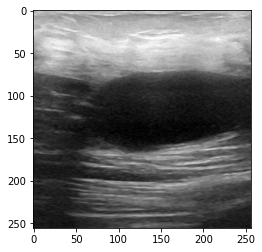

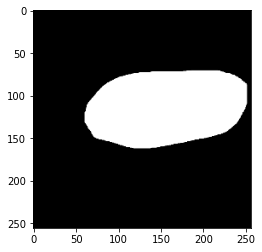

/_chenqi45w/anaconda3/envs/unext/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


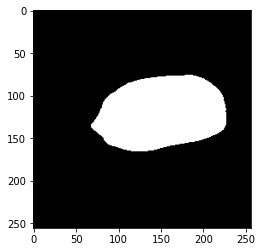

0.7342511474521964 0.846764493748084


In [10]:
result_img_dir = os.path.join('./result_img',config['dataset'])
valid_img_ids = np.load(os.path.join('./datasets',config['dataset'],'valid_img_ids.npy'))
valid_img = valid_img_ids[1]

img = np.load(os.path.join('./datasets',config['dataset'],'images',valid_img))
plt.imshow(img.transpose(1,2,0))
plt.show()

mask = np.load(os.path.join('./datasets',config['dataset'],'masks',valid_img))
plt.imshow(mask.transpose(1,2,0),cmap = "gray")
plt.show()

model.eval()
model = model.cuda()
img1 = torch.Tensor(img).unsqueeze(0).cuda()
pred = model(img1)
pred = pred.squeeze(0).detach().cpu().numpy()
plt.imshow(pred.transpose(1,2,0) > 0.5,cmap = "gray")
plt.show()

iou,dice = iou_score(pred, mask)
print(iou,dice )

config['result_img_dir_valid'] = os.path.join(result_img_dir,valid_img.split('.')[0])
plt.imsave(os.path.join(config['result_img_dir_valid'] ,'DS_STM_Net.png'),(pred > 0.5)[0],cmap='gray')

In [11]:
def save_all_test(model,img,mask):
    model.eval()
    model = model.cuda()
    img1 = torch.Tensor(img).unsqueeze(0).cuda()
    pred = model(img1)
    pred = pred.squeeze(0).detach().cpu().numpy()
    
    plt.imsave(os.path.join(config['result_img_dir_valid'] ,'DS_STM_Net.png'),(pred > 0.5)[0],cmap='gray')
    
from tqdm import tqdm
pbar = tqdm(total=len(valid_img_ids))
for valid_img in valid_img_ids:
    img = np.load(os.path.join('./datasets',config['dataset'],'images',valid_img))
    mask = np.load(os.path.join('./datasets',config['dataset'],'masks',valid_img))
    save_all_test(model,img,mask)
    config['result_img_dir_valid'] = os.path.join(result_img_dir,valid_img.split('.')[0])
    postfix = OrderedDict([
        ('loss', 0)
    ])
    pbar.set_postfix(postfix)
    pbar.update(1)
pbar.close()

100%|██████████| 130/130 [00:12<00:00, 10.64it/s, loss=0]
